# Neural Networks

Neural Networks can be constructed using the torch.nn package.

Now that you had a glimpse of `autograd`, `nn`, depends on `autograd` to define models and differentiate them. An `nn.Module` contains layers, and a method `forward(input)` that returns the `output`.


For example, look at this network that classifies digit images:

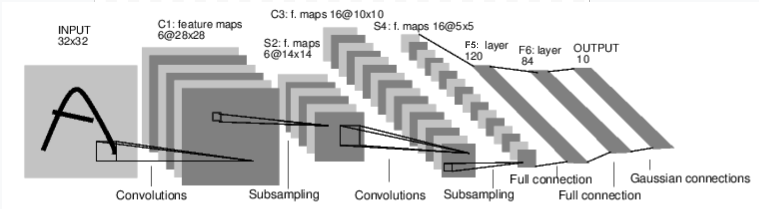


It is a simple feed-forward network. It takes the input, feeds it through several layers one after the other, and then finally gives the output.

A typical training procedure for a neural network is as follows:



*   Define the neural network that has some learnable parameters (or weights)
*   Iterate over a dataset of inputs
*   Process input through the network
*   Compute the loss (how far is the output is correct)
*   Propagate gradients back into the network's parameters
*   Update the weights of the network, typically using a simple update rule: `weight = weight - learning_rate * gradient`



## Define the network

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

  def __init__(self):
    super(Net, self).__init__()
    # 1 input image channel, 6 output channels, 5x5 square convolution
    # kernel
    self.conv1 = nn.Conv2d(1, 6, 5)
    self.conv2 = nn.Conv2d(6, 16, 5)
    # an affine operation: y = Wx + b
    self.fc1 = nn.Linear(16 * 5 * 5, 120) # 5x5 from image dimension
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, input):
    # Convolutional layer C1: 1 input image channel, 6 output channels,
    # 5x5 square convolution, it uses RELU activation function, and
    # outputs a Tensor with size (N, 6, 28, 28), where N is the size of the batch
    c1 = F.relu(self.conv1(input))

    # Subsampling layer S2: 2x2 grid, purely functional
    # this layer does not have any parameter, and outputs a (N, 6, 14, 14) Tensor
    s2 = F.max_pool2d(c1, (2, 2))

    # Convolutional layer C3: 6 input channels, 16 output channels,
    # 5x5 square convolution, it uses RELU activation function, and
    # outputs a (N, 16, 10, 10)
    c3 = F.relu(self.conv2(s2))

    # Subsampling layer S4: 2x2 grid, purely functional,
    # this layer does not have any parameter, and outputs a (N, 16, 5, 5)
    s4 = F.max_pool2d(c3, 2)

    # Flatten operation: purely functional, outputs a (N, 400) Tensor
    s4 = torch.flatten(s4, 1)

    # Fully connected layer F5: (N, 400) Tensor input,
    # and outputs a (N, 120) Tensor, it uses RELU activation function
    f5 = F.relu(self.fc1(s4))

    # Fully connected layer F6: (N, 120) Tensor input,
    # and outputs a (N, 84) Tensor, it uses RELU activation function
    f6 = F.relu(self.fc2(f5))

    # Gaussian layer OUTPUT: (N, 84) Tensor input, and
    # outputs a (N, 10) Tensor
    output = self.fc3(f6)
    return output


net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


We just have to define the `forward` function, and the `backward` function (where gradients are computed) is automatically defined for you using `autograd`. You can use any of the Tensor operations in the `forward` function.

The learnable parameters of a model are returned by `net.parameters()`



In [35]:
params = list(net.parameters())
print(len(params))
print(params[0].size()) # conv1's .weight

10
torch.Size([6, 1, 5, 5])


Let's try a random 32x32 input. Note: expected input size of this net (LeNet) is 32x32. To use this net on MNIST dataset, please resize the images from the dataset to 32x32.

In [36]:
input = torch.randn(1, 1, 32, 32)
out = net(input)
print(out)

tensor([[ 0.0181,  0.0412,  0.0248, -0.0243, -0.1752, -0.0420,  0.0423,  0.1616,
          0.0754, -0.0798]], grad_fn=<AddmmBackward0>)


Zero the gradient buffers of all parameters and backprops with random gradients:



In [37]:
net.zero_grad()
out.backward(torch.randn(1, 10))

### Note

`torch.nn` only supports mini-batches. The entire `torch.nn` package only supports inputs that are a mini-batch of samples, and not a single sample.

For example, `nn.Conv2d` will take in a 4D Tensor of `nSamples` x `nChannels` x `Height` x `Width`.

If you have a single sample, just use `input.unsqueeze(0)` to add a fake batch dimension.

### Recap

* `torch.Tensor` - A multi-dimensional array with support for autograd operations like `backward()`. Also holds the gradient w.r.t. the tensor.

* `nn.Module` - Neural network module. Convenient way of encapsulating parameters, with helpers for moving them to GPU, exporting, loading, etc.

* `nn.Parameter` - A kind of Tensor, that is automatically registered as a parameter when assigned as an attribute to a `Module`.

* `autograd.Function` - Implements forward and backward definitions of an autograd operation. Every Tensor operation creates at least a single `Function` node that connects to functions that created a Tensor and encodes its history.

## Loss Functions

A loss function takes the (output, target) pair of inputs, and computes a value that estimates how far away the output is from the target.


There are several different [loss functions](https://pytorch.org/docs/stable/nn.html#loss-functions) under the nn package. A simple loss is: `nn.MSELoss` which computes the mean-squared error between the output and the target.

In [42]:
output = net(input)
target = torch.randn(10) # a dummy target, for example
target = target.view(1, -1) # make it the same shape as output
criterion = nn.MSELoss()

loss = criterion(output, target)
print(loss)

tensor(1.1335, grad_fn=<MseLossBackward0>)


Now, if you follow `loss` in the backward direction, using its `.grad_fn` attribute, you will see a graph of computations that looks like this:

input -> conv2d -> relu -> maxpool2d -> conv2d -> relu -> maxpool2d
      -> flatten -> linear -> relu -> linear -> relu -> linear
      -> MSELoss
      -> loss


So, when we call `loss.backward()`, the whole graph is differentiated w.r.t. the neural net parameters, and all Tensors in the graph that have `requires_grad=True` will have their `.grad` Tensor accumulated with the gradient.

For illustration, let us follow a few steps backward:



In [39]:
print(loss.grad_fn) # MSELoss

print(loss.grad_fn.next_functions[0][0]) # Linear

print(loss.grad_fn.next_functions[0][0].next_functions[0][0]) # ReLU

## Backprop

To backpropagate the error all we have to do is to `loss.backward()`. You need to clear the existing gradients though, else gradients will be accumulated to existing gradients.

In PyTorch, gradients are **accumulated** by default whenever `.backward()` is called. This means that if you don’t clear the gradients before each backpropagation, the new gradients will be **added** to the gradients from previous backpropagation steps. This is usually not what we want, as it can lead to incorrect gradient values and therefore incorrect parameter updates.

Here’s why you need to clear the gradients:

1. **Avoid Gradient Accumulation**: During training, each batch of data should compute its own independent gradient. If gradients from previous batches are not cleared, the accumulated gradients will effectively "double count" or add up across batches, leading to incorrect updates.

2. **Ensuring Correct Updates**: In each training step, the optimizer uses the computed gradients to update the model's parameters. If gradients are not reset, they don’t reflect only the current batch’s error but an accumulation from previous batches, leading to larger updates than intended.

3. **Efficiency in Batch Training**: For mini-batch training, we want gradients to reflect only the error contribution from the current mini-batch. Clearing gradients ensures that each batch has an independent influence on the parameter updates.

To clear the gradients in PyTorch, use:
```python
optimizer.zero_grad()
```

### Example Workflow
Here's how it typically looks in a training loop:
```python
for data, target in training_data:
    optimizer.zero_grad()       # Clear previous gradients
    output = model(data)        # Forward pass
    loss = loss_fn(output, target)  # Compute loss
    loss.backward()             # Backpropagate to compute gradients
    optimizer.step()            # Update parameters
```

In this way, `.zero_grad()` ensures that each batch has a fresh set of gradients, allowing your model to learn effectively without unintended accumulation from previous steps.



Now we shall call `loss.backward()`, and have a look at conv1’s bias gradients before and after the backward.

In [43]:
net.zero_grad() # zeros the gradient buffers of all elements

print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

loss.backward()

print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)


conv1.bias.grad before backward
None
conv1.bias.grad after backward
tensor([ 0.0003, -0.0123,  0.0021,  0.0136,  0.0005,  0.0041])


## Update the weights

The simplest update rule used in practice is the Stochastic Gradient Descent (SGD):

`weight = weight - learning_rate * gradient`

We can implement this using simple Python code:


```python
learning_rate = 0.01
for f in net.parameters():
  f.data.sub_(f.grad.data * learning_rate)
```

However, as you use neural networks, you want to use various different update rules such as SGD, Nesterov-SGD, Adam, RMSProp, etc. There is a small package for this: `torch.optim` that implements all these methods. Using it is very simple:

```python
import torch.optim as optim

# create your optimizer
optimizer = optim.SGD(net.parameters(), lr=0.01)

# in your training loop:
optimizer.zero_grad()   # zero the gradient buffers
output = net(input)
loss = criterion(output, target)
loss.backward()
optimizer.step()    # Does the update
````

